# Aufenthaltsdauer in Zuständen aus Rohdaten

Offenes / Unklares: 
* Wie umgehen mit Fahrten die nicht zuhause enden? 
* Wie Aufenthaltsdauer des Endzustands berechnen? ->  *Ankuftszeit Endzustand bis erste Abfahrtszeit erste Fahrt?* 

### Zustände

* Zuhause -> 1
* Arbeit -> 2 
* Einkaufen -> 3 
* Freizeit -> 4
* Sonstiges -> 5

In [26]:
import pandas as pd
import numpy as np 
import matplotlib as mlp
import matplotlib.pyplot as pl
import seaborn as sns

In [2]:
df = pd.read_csv(r'C:\Users\thoma\Desktop\ev-modelling-repo\Data\NHTS_trips_processed.csv')

In [3]:
df["aufenthalt"] = 0

In [4]:
filt = df["ST_WOTAG"] < 6
df = df[filt]

In [5]:
df = df.sort_values(by=['ID', 'W_NR'])

In [6]:
df.reset_index(inplace=True)

In [7]:
df.tail(100)

,index,ID,ST_WOTAG,WHYFROM,zweck,W_NR,TRPTRANS,wegkm,wegmin_imp1,W_SZ,W_AZ,W_SZ_MIN,W_AZ_MIN,W_SZ_t,aufenthalt
737440,923504,407942332,1,1,5,5,3,9.939,10,1500,1510,900,910,60,0
737441,923505,407942332,1,5,2,6,3,9.588,10,1615,1625,975,985,65,0
737442,923506,407942351,1,1,4,1,6,21.831,20,1000,1020,600,620,40,0
737443,923507,407942351,1,4,4,2,6,21.827,29,1530,1559,930,959,62,0
737444,923508,407942351,1,4,3,3,6,17.500,21,1715,1736,1035,1056,69,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737535,745650,4045582510,3,5,5,4,6,4.310,7,753,800,473,480,32,0
737536,745651,4045582510,3,5,3,5,6,3.421,17,803,820,483,500,32,0
737537,745652,4045582510,3,3,1,6,6,11.676,40,920,1000,560,600,37,0
737538,745653,4045582510,3,1,2,7,6,55.371,40,1520,1600,920,960,61,0


In [8]:
df.drop(columns=["index"], inplace=True)

In [9]:
person_grpd = df.groupby(['ID'], as_index=False)

In [10]:
def calc_aufenthalt(df):
    rows = df.shape[0]
    for i in range(rows):
        # letzter Trip der Person -> Aufenthalt = Zeit bis zum ersten Trip 
        if (i == rows-1) or (df.at[i+1, "ID"] != df.at[i, "ID"]):
            # Beispiel: Wenn Wegnummer = 3 liegt Index des ersten Wegs 2 Schritte zurück
            index_first_trip = i - (df.at[i, "W_NR"] - 1) 
            start_first_trip = df.at[index_first_trip, "W_SZ_MIN"]
            end_trip = df.at[i,"W_AZ_MIN"]
            # Gesamtaufenthalt = 
            # Rest des Tages + Zeit bis zum ersten Trip
            if end_trip > start_first_trip:           
                df.at[i, "aufenthalt"] = 1440 - end_trip + start_first_trip
            # Wenn letzte Fahrt nach 24:00
            elif end_trip < start_first_trip:
                df.at[i, "aufenthalt"] = start_first_trip - end_trip
        else:
            end_trip = df.at[i, "W_AZ_MIN"]
            start_next_trip = df.at[i+1, "W_SZ_MIN"]
            aufenthalt = start_next_trip - end_trip
            # wenn Aufenthalt < 0 ist nächster Trip nach 24:00 
            if aufenthalt < 0:
                aufenthalt = (1440 - end_trip) + start_next_trip
            df.at[i, "aufenthalt"] = aufenthalt
        
    

In [11]:
calc_aufenthalt(df)

In [12]:
filt = df["zweck"] == 1
aufenthalt_zuhause = df[filt]["aufenthalt"]
filt = df["zweck"] == 2
aufenthalt_arbeit = df[filt]["aufenthalt"]
filt = df["zweck"] == 3
aufenthalt_einkaufen = df[filt]["aufenthalt"]
filt = df["zweck"] == 4
aufenthalt_freizeit = df[filt]["aufenthalt"]
filt = df["zweck"] == 5
aufenthalt_sonstiges = df[filt]["aufenthalt"]

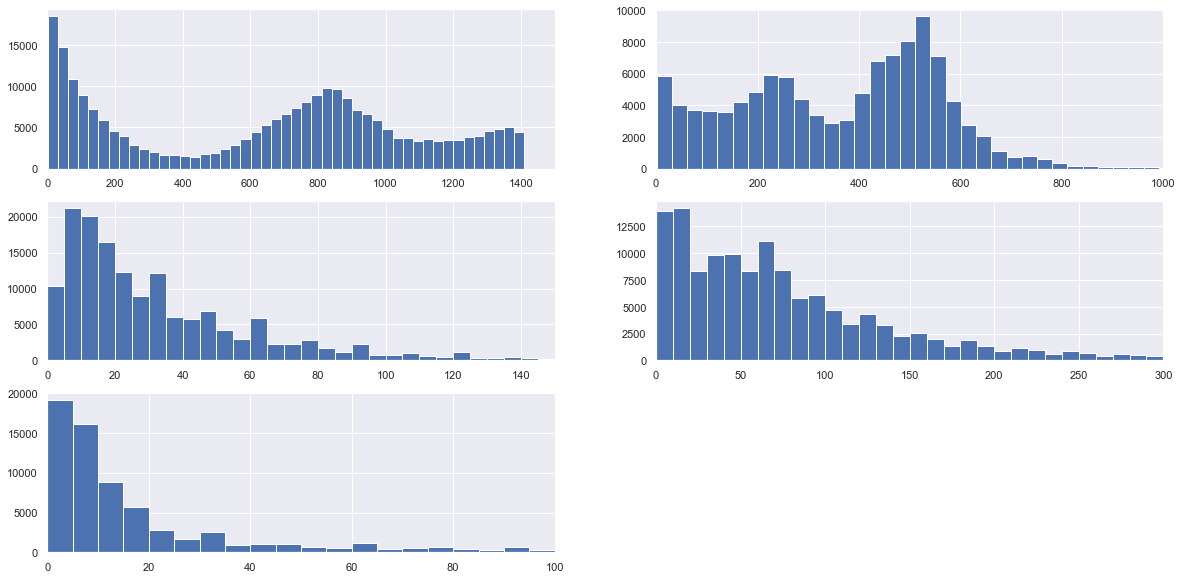

In [29]:
sns.set()
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,10))
ax1.hist(aufenthalt_zuhause, bins=range(int(min(aufenthalt_zuhause)), int(max(aufenthalt_zuhause)), 30));
ax1.set_xlim([0, 1500])
ax2.hist(aufenthalt_arbeit, bins=range(int(min(aufenthalt_arbeit)), int(max(aufenthalt_arbeit)), 30));
ax2.set_xlim([0,1000])
ax3.hist(aufenthalt_einkaufen, bins=range(int(min(aufenthalt_einkaufen)), int(max(aufenthalt_einkaufen)), 5));
ax3.set_xlim([0,150])
ax4.hist(aufenthalt_freizeit, bins=range(int(min(aufenthalt_freizeit)), int(max(aufenthalt_freizeit)), 10));
ax4.set_xlim([0,300])
ax5.hist(aufenthalt_sonstiges, bins=range(int(min(aufenthalt_sonstiges)), int(max(aufenthalt_sonstiges)), 5));
ax5.set_xlim([0,100])
fig.delaxes(ax6)



## Verteilungsfunktion über Density Estimation Modell

In [30]:
from sklearn.neighbors import KernelDensity

In [46]:
# Erstellen Kernel Density Estimation Modell Zuhause 
kde_model_zuhause = KernelDensity(bandwidth=13)
kde_model_zuhause.fit(aufenthalt_zuhause[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(0, max(aufenthalt_zuhause), 1000)
log_pdf = kde_model_zuhause.score_samples(x[:, np.newaxis])
kde_zuhause_pdf = np.exp(log_pdf)

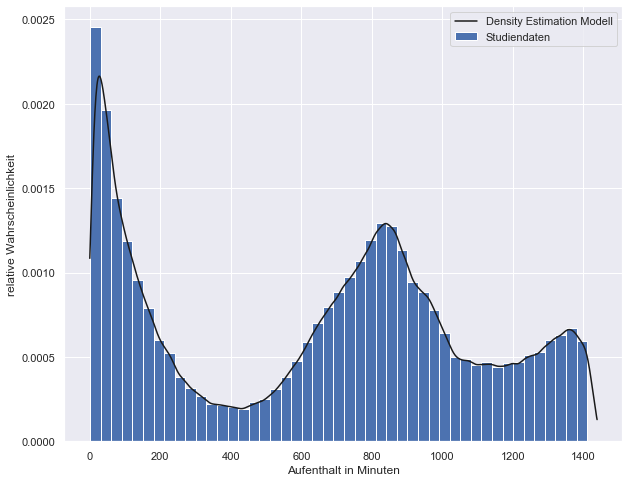

In [47]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_zuhause, bins=range(int(min(aufenthalt_zuhause)), int(max(aufenthalt_zuhause)), 30), density=True);
plt.plot(x, kde_zuhause_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [57]:
# Erstellen Kernel Density Estimation Modell Arbeit 
kde_model_arbeit = KernelDensity(bandwidth=18)
kde_model_arbeit.fit(aufenthalt_arbeit[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(0, max(aufenthalt_arbeit), 1000)
log_pdf = kde_model_arbeit.score_samples(x[:, np.newaxis])
kde_arbeit_pdf = np.exp(log_pdf)

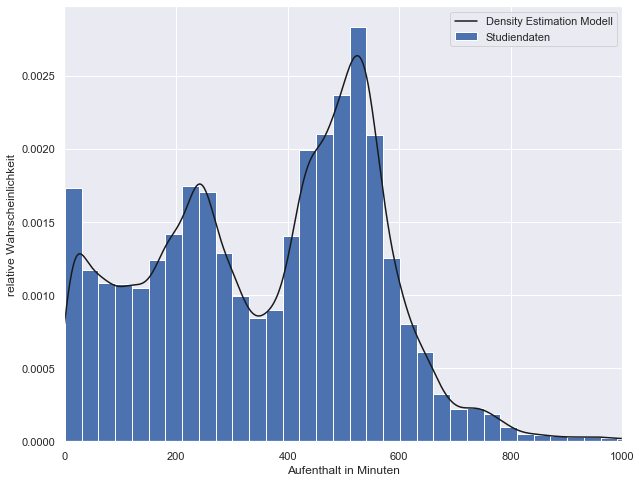

In [60]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_arbeit, bins=range(int(min(aufenthalt_arbeit)), int(max(aufenthalt_arbeit)), 30), density=True);
plt.plot(x, kde_arbeit_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(0, 1000)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [69]:
# Erstellen Kernel Density Estimation Modell Einkaufen 
kde_model_einkaufen = KernelDensity(bandwidth=8)
kde_model_einkaufen.fit(aufenthalt_einkaufen[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(0, max(aufenthalt_einkaufen), 1000)
log_pdf = kde_model_einkaufen.score_samples(x[:, np.newaxis])
kde_einkaufen_pdf = np.exp(log_pdf)

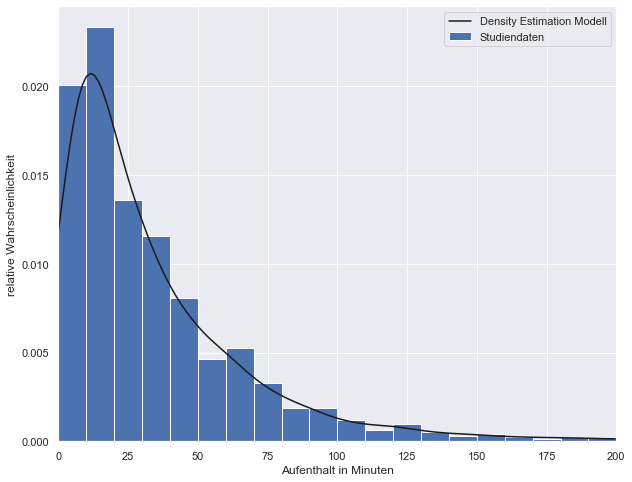

In [70]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_einkaufen, bins=range(int(min(aufenthalt_einkaufen)), int(max(aufenthalt_einkaufen)), 10), density=True);
plt.plot(x, kde_einkaufen_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(0, 200)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [81]:
# Erstellen Kernel Density Estimation Modell Freizeit
kde_model_freizeit = KernelDensity(bandwidth=6)
kde_model_freizeit.fit(aufenthalt_freizeit[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(0, max(aufenthalt_freizeit), 1000)
log_pdf = kde_model_freizeit.score_samples(x[:, np.newaxis])
kde_freizeit_pdf = np.exp(log_pdf)

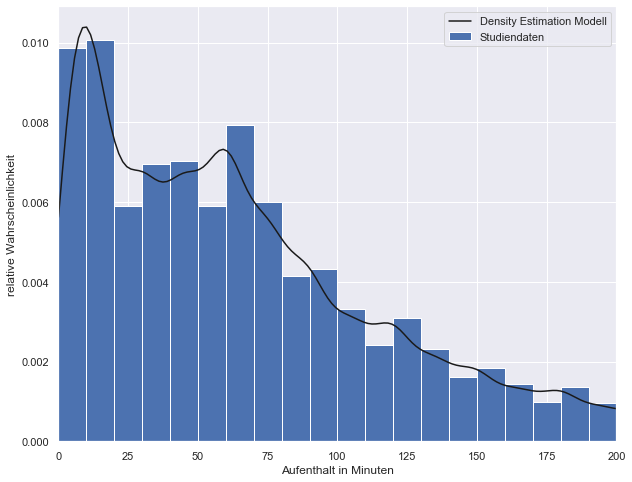

In [82]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_freizeit, bins=range(int(min(aufenthalt_freizeit)), int(max(aufenthalt_freizeit)), 10), density=True);
plt.plot(x, kde_freizeit_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(0, 200)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [92]:
# Erstellen Kernel Density Estimation Modell Sonstiges
kde_model_sonstiges = KernelDensity(bandwidth=4)
kde_model_sonstiges.fit(aufenthalt_sonstiges[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
x = np.linspace(0, max(aufenthalt_sonstiges), 1000)
log_pdf = kde_model_sonstiges.score_samples(x[:, np.newaxis])
kde_sonstiges_pdf = np.exp(log_pdf)

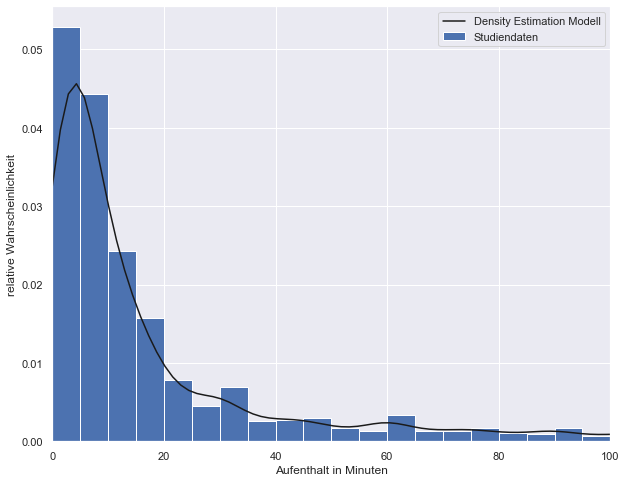

In [93]:
plt.figure(figsize=(10,8))
plt.hist(aufenthalt_sonstiges, bins=range(int(min(aufenthalt_sonstiges)), int(max(aufenthalt_sonstiges)), 5), density=True);
plt.plot(x, kde_sonstiges_pdf, '-k');
labels = ["Density Estimation Modell", "Studiendaten"]
plt.legend(labels);
plt.gca().set_xlim(0, 100)
plt.xlabel("Aufenthalt in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

## Modelle speichern

In [102]:
from pathlib import Path
import pickle
import os

root = os.getcwd()
if not os.path.exists(os.getcwd()+ "\\Simulationsdaten"):
    os.makedirs(root+"\\Simulationsdaten")

# Modelle in Liste zusammenfassen
models = [kde_model_zuhause, kde_model_arbeit, kde_model_einkaufen, kde_model_freizeit, kde_model_sonstiges]
    
path = root+"\\Simulationsdaten"+"\\Modelle_Aufenthaltsdauer_Werktag.pickle"
pickle.dump(models, open(path, "wb"))
